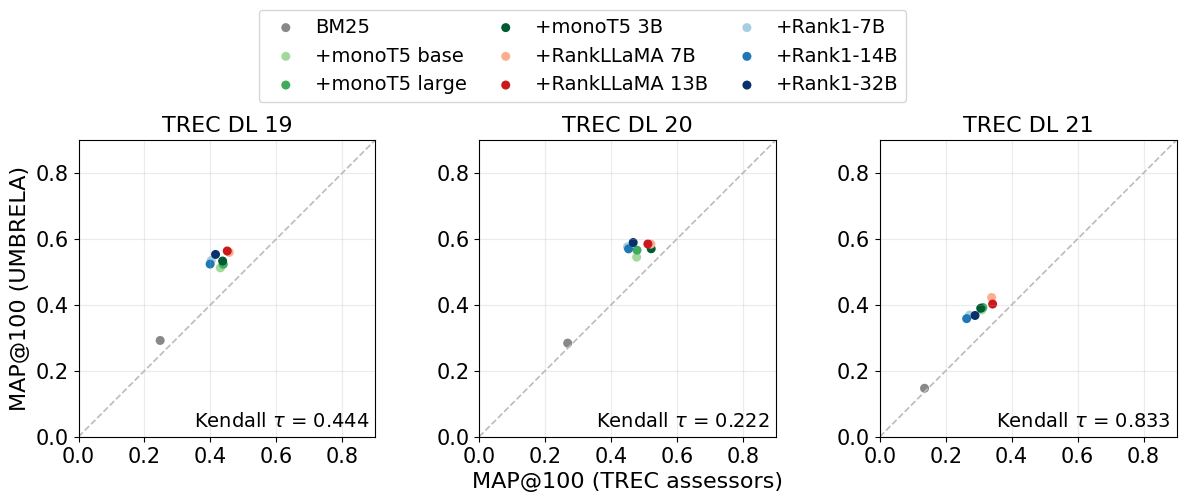

Saved: /content/plots_bias_scatter/trec_assessors_vs_family.umbrela.pdf


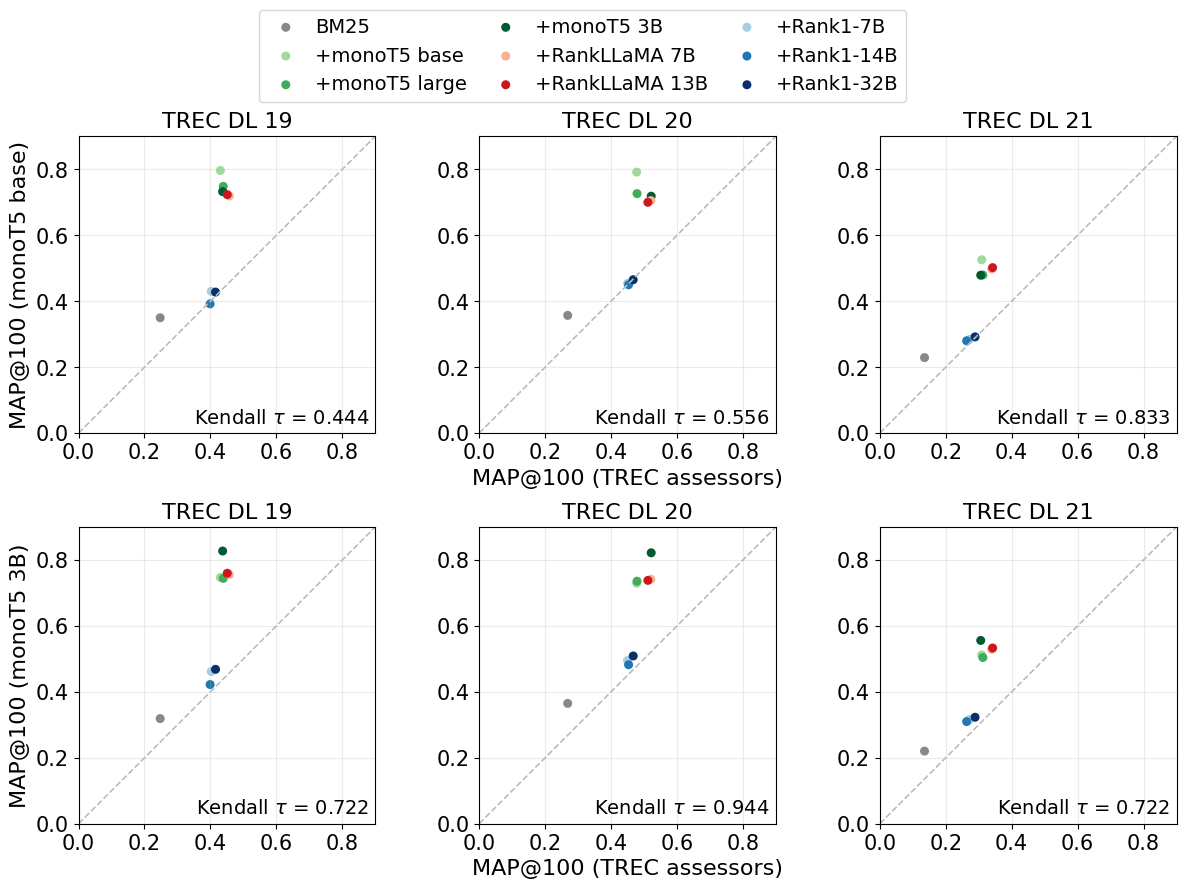

Saved: /content/plots_bias_scatter/trec_assessors_vs_family.monot5.pdf


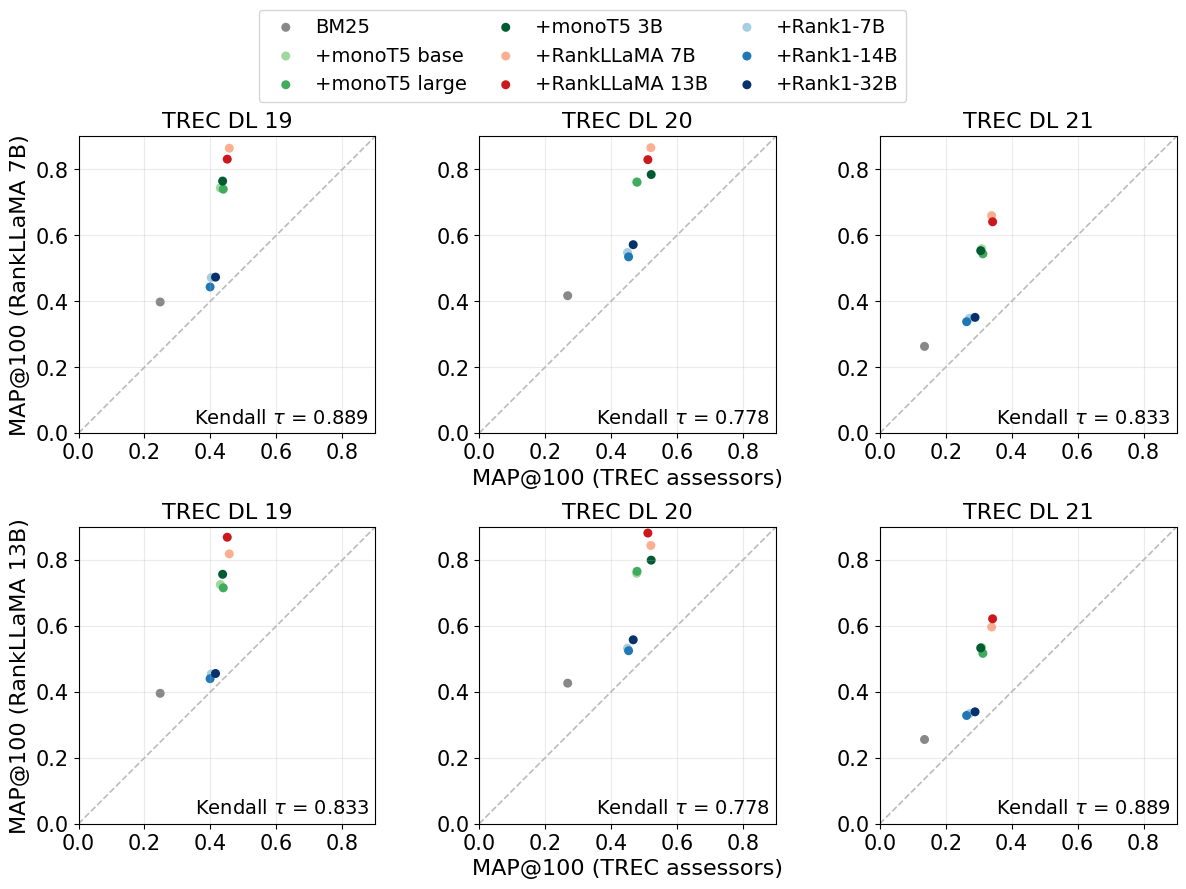

Saved: /content/plots_bias_scatter/trec_assessors_vs_family.rankllama.pdf


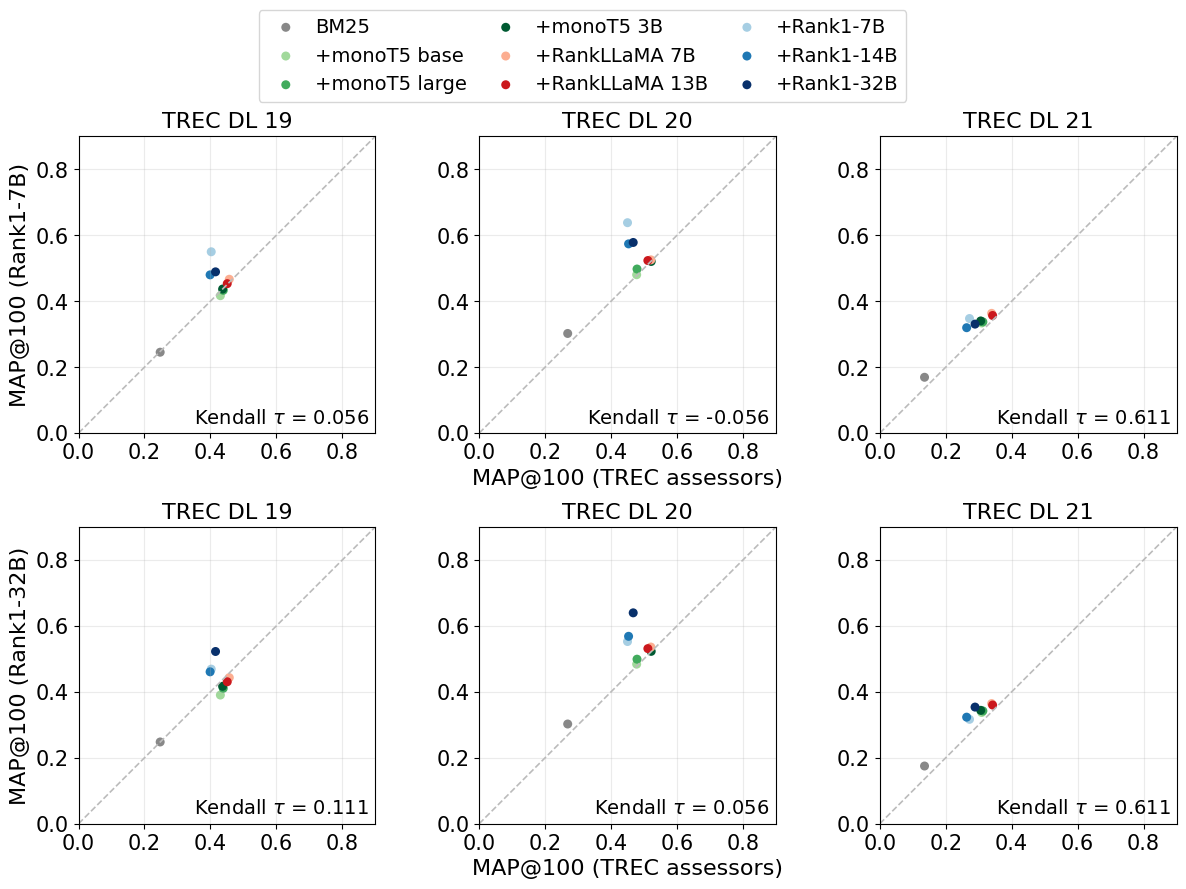

Saved: /content/plots_bias_scatter/trec_assessors_vs_family.rank1.pdf
✅ All figures saved and zipped to: /content/plots_bias_scatter.zip


In [ ]:
import os, json, shutil
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

TITLE_FS, LABEL_FS, TICK_FS, LEGEND_FS, ANNO_FS = 16, 16, 15, 14, 14
plt.rcParams.update({
    "axes.titlesize": TITLE_FS,
    "axes.labelsize": LABEL_FS,
    "xtick.labelsize": TICK_FS,
    "ytick.labelsize": TICK_FS,
    "legend.fontsize": LEGEND_FS,
})


ROOT_RPB = "/output/rq3/ranking_performance"
ROOT_SR  = "/result/rq3/system_ranking"


DATASETS = OrderedDict([
    ("dl19-passage", "TREC DL 19"),
    ("dl20-passage", "TREC DL 20"),
    ("dl21-passage", "TREC DL 21"),
])


EVAL_DISPLAY = {
    "nist": "TREC assessors",
    "gpt-4o_0123_100_0_1": "UMBRELA",
    "monot5-base-gen": "monoT5 base",
    "monot5-large-gen": "monoT5 large",
    "monot5-3b-gen": "monoT5 3B",
    "rank1-7b-gen": "Rank1-7B",
    "rank1-14b-gen": "Rank1-14B",
    "rank1-32b-awq-gen": "Rank1-32B",
    "rankllama-7b-mapthreshold": "RankLLaMA 7B",
    "rankllama-13b-mapthreshold": "RankLLaMA 13B",
}


LEGEND_ORDERED_LABELS = [
    "BM25", "+monoT5 base", "+monoT5 large", "+monoT5 3B",
    "+RankLLaMA 7B", "+RankLLaMA 13B",
    "+Rank1-7B", "+Rank1-14B", "+Rank1-32B",
]
RUN_MATCHERS = [
    "run.bm25-1000.dl",
    "run.bm25-1000--monot5-base-msmarco",
    "run.bm25-1000--monot5-large-msmarco",
    "run.bm25-1000--monot5-3b-msmarco",
    "run.bm25-1000--rankllama-v1-7b-lora-passage",
    "run.bm25-1000--rankllama-v1-13b-lora-passage",
    "run.bm25-1000--rank1-7b",
    "run.bm25-1000--rank1-14b",
    "run.bm25-1000--rank1-32b-awq",
]
RUN_FAMILIES = [
    "bm25",
    "monot5", "monot5", "monot5",
    "rankllama", "rankllama",
    "rank1", "rank1", "rank1",
]
FAMILY_COLORS = {
    "bm25": ["#888888"],
    "monot5": ["#a1d99b", "#41ab5d", "#005a32"],
    "rankllama": ["#fcae91", "#cb181d"],
    "rank1": ["#a6cee3", "#1f78b4", "#08306b"],
}
RUN_COLORS = []
_counters = {"bm25":0, "monot5":0, "rank1":0, "rankllama":0}
for fam in RUN_FAMILIES:
    palette = FAMILY_COLORS[fam]
    idx = _counters[fam]
    RUN_COLORS.append(palette[min(idx, len(palette)-1)])
    _counters[fam] += 1


def load_json(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def file_rpb(evaluator, dataset):
    return os.path.join(ROOT_RPB, f"ranking_performance.{evaluator}.{dataset}.json")

def file_sr(evaluator, dataset):
    return os.path.join(ROOT_SR, f"result.{evaluator}.{dataset}.json")

def pick_map100_from(obj, match):
    for k, metrics in obj.items():
        if match in k and isinstance(metrics, dict) and "map@100" in metrics:
            return float(metrics["map@100"])
    return None

def load_kendall_tau_map100(evaluator, dataset):
    p = file_sr(evaluator, dataset)
    if not os.path.isfile(p): return None
    try:
        obj = load_json(p)
        return float(obj["gen"]["metrics"]["map@100"]["kendall_tau"])
    except Exception:
        return None


def scatter_panel(ax, evaluator, dataset_key, dataset_label):
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(0.0, 0.9); ax.set_ylim(0.0, 0.9)
    ticks = np.arange(0.0, 0.91, 0.2)
    ax.set_xticks(ticks); ax.set_yticks(ticks)

    nist_path = file_rpb("nist", dataset_key)
    eval_path = file_rpb(evaluator, dataset_key)
    if not (os.path.isfile(nist_path) and os.path.isfile(eval_path)):
        ax.set_visible(False)
        return []

    x_obj, y_obj = load_json(nist_path), load_json(eval_path)
    handles = []
    for label, matcher, color in zip(LEGEND_ORDERED_LABELS, RUN_MATCHERS, RUN_COLORS):
        x = pick_map100_from(x_obj, matcher)
        y = pick_map100_from(y_obj, matcher)
        if x is None or y is None:
            continue
        h = ax.scatter([x], [y], s=42, c=[color], edgecolors="none", label=label)
        handles.append(h)

    # y=x
    ax.plot([0, 0.9], [0, 0.9], "--", c="#bbbbbb", lw=1.2)

    tau = load_kendall_tau_map100(evaluator, dataset_key)
    if tau is not None:
        ax.text(0.98, 0.02, f"Kendall $\\tau$ = {tau:.3f}",
                transform=ax.transAxes, ha="right", va="bottom",
                fontsize=ANNO_FS, color="black")

    ax.set_title(dataset_label, pad=6, fontweight="normal")
    ax.grid(alpha=0.25)
    return handles

def plot_group(fig_prefix, eval_rows):
    n_rows, n_cols = len(eval_rows), len(DATASETS)
    fig_w, fig_h = n_cols * 4.0, n_rows * 4.0 + 1.8
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h))
    if n_rows == 1: axes = [list(axes)]

    legend_handles = None

    for r, evaluator in enumerate(eval_rows):
        for c, (ds_key, ds_label) in enumerate(DATASETS.items()):
            ax = axes[r][c]
            handles = scatter_panel(ax, evaluator, ds_key, ds_label)
            if legend_handles is None and handles:
                legend_handles = handles

            if c == n_cols // 2:
                ax.set_xlabel("MAP@100 (TREC assessors)", fontsize=LABEL_FS)
            else:
                ax.set_xlabel("")

            if c == 0:
                ax.set_ylabel(f"MAP@100 ({EVAL_DISPLAY.get(evaluator, evaluator)})",
                              fontsize=LABEL_FS)
            else:
                ax.set_ylabel("")

    if legend_handles:
        fig.legend(
            handles=legend_handles,
            labels=LEGEND_ORDERED_LABELS,
            loc="upper center",
            bbox_to_anchor=(0.5, 0.955),
            ncol=3, frameon=True,
            columnspacing=1.0, handletextpad=0.5, borderaxespad=0.0
        )


    hspace = 0.28 if n_rows == 2 else 0.40
    fig.tight_layout()
    fig.subplots_adjust(
        top=0.83,
        left=0.08, right=0.995, bottom=0.12,
        wspace=0.35, hspace=hspace
    )

    outdir = "/plot/rq3/"
    os.makedirs(outdir, exist_ok=True)
    outpath = os.path.join(outdir, f"{fig_prefix}.pdf")
    plt.savefig(outpath, format="pdf", bbox_inches="tight")
    display(fig)
    plt.close(fig)
    print("Saved:", outpath)

GROUP_UMBRELA = ["gpt-4o_0123_100_0_1"]
GROUP_MONOT5  = ["monot5-base-gen", "monot5-3b-gen"]
GROUP_RLLAMA  = ["rankllama-7b-mapthreshold", "rankllama-13b-mapthreshold"]
GROUP_RANK1   = ["rank1-7b-gen", "rank1-32b-awq-gen"]


plot_group("trec_assessors_vs_family.umbrela", GROUP_UMBRELA)
plot_group("trec_assessors_vs_family.monot5", GROUP_MONOT5)
plot_group("trec_assessors_vs_family.rankllama", GROUP_RLLAMA)
plot_group("trec_assessors_vs_family.rank1", GROUP_RANK1)
